In [2]:
import desiutil
from desispec.io import read_spectra
from desitarget.targetmask import desi_mask, bgs_mask
from desitarget.cmx.cmx_targetmask import cmx_mask

from astropy.io import fits
from astropy.table import Table, vstack

from glob import glob

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('font', size =16)

## Target Bitmasks

All tiles from spring 2020 should have a CMX_TARGET number that should use the cmx_mask to check for target types, but just for the heck of it print some additional desi and bgs bit masks.

In [3]:
cmx_bgs_bits = '|'.join([_ for _ in cmx_mask.names() if 'BGS' in _])
print(cmx_bgs_bits)
print([cmx_mask.bitnum(_) for _ in cmx_bgs_bits.split('|')])

SV0_BGS|MINI_SV_BGS_BRIGHT
[8, 56]


In [4]:
bgs_bits = '|'.join([_ for _ in bgs_mask.names() if 'BGS' in _])
print(bgs_bits)
print([bgs_mask.bitnum(_) for _ in bgs_bits.split('|')])

BGS_FAINT|BGS_BRIGHT|BGS_WISE|BGS_FAINT_HIP|BGS_FAINT_NORTH|BGS_BRIGHT_NORTH|BGS_WISE_NORTH|BGS_FAINT_SOUTH|BGS_BRIGHT_SOUTH|BGS_WISE_SOUTH
[0, 1, 2, 3, 8, 9, 10, 16, 17, 18]


In [5]:
desi_bgs_bits = '|'.join([_ for _ in desi_mask.names() if 'BGS' in _])
print(desi_bgs_bits)
print([desi_mask.bitnum(_) for _ in desi_bgs_bits.split('|')])

BGS_ANY
[60]


## Coadds from Spectroscopic Pipeline

In [6]:
coadds = sorted(glob('/global/project/projectdirs/desi/spectro/redux/daily/tiles/68000/20200314/coadd*.fits'))
coadds

['/global/project/projectdirs/desi/spectro/redux/daily/tiles/68000/20200314/coadd-0-68000-20200314.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/68000/20200314/coadd-1-68000-20200314.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/68000/20200314/coadd-2-68000-20200314.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/68000/20200314/coadd-3-68000-20200314.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/68000/20200314/coadd-4-68000-20200314.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/68000/20200314/coadd-5-68000-20200314.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/68000/20200314/coadd-6-68000-20200314.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/68000/20200314/coadd-7-68000-20200314.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/68000/20200314/coadd-8-68000-20200314.fits',
 '/global/project/projectdirs/desi/spectro/red

### Joined Fibermaps

Read through all the coadds and vstack the fibermaps so that we can look at the full camera for this tile.

In [7]:
spec_fibermaps = None
for coadd in coadds:
    spectra = read_spectra(coadd)
    if spec_fibermaps is None:
        spec_fibermaps = spectra.fibermap
    else:
        spec_fibermaps = vstack([spec_fibermaps, spectra.fibermap])

In [8]:
spec_fibermaps

TARGETID,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,PMRA_IVAR,PMDEC_IVAR,REF_EPOCH,LAMBDA_REF,FA_TARGET,FA_TYPE,OBJTYPE,FIBERASSIGN_X,FIBERASSIGN_Y,NUMTARGET,PRIORITY,SUBPRIORITY,OBSCONDITIONS,NUMOBS_MORE,RELEASE,BRICKID,BRICKNAME,BRICK_OBJID,MORPHTYPE,TARGET_RA_IVAR,TARGET_DEC_IVAR,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,FRACFLUX_G,FRACFLUX_R,FRACFLUX_Z,FRACMASKED_G,FRACMASKED_R,FRACMASKED_Z,FRACIN_G,FRACIN_R,FRACIN_Z,NOBS_G,NOBS_R,NOBS_Z,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,ALLMASK_G,ALLMASK_R,ALLMASK_Z,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,WISEMASK_W1,WISEMASK_W2,MASKBITS,FRACDEV,FRACDEV_IVAR,SHAPEDEV_R,SHAPEDEV_E1,SHAPEDEV_E2,SHAPEDEV_R_IVAR,SHAPEDEV_E1_IVAR,SHAPEDEV_E2_IVAR,SHAPEEXP_R,SHAPEEXP_E1,SHAPEEXP_E2,SHAPEEXP_R_IVAR,SHAPEEXP_E1_IVAR,SHAPEEXP_E2_IVAR,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_RP_MEAN_MAG,GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_RP_EXCESS_FACTOR,GAIA_ASTROMETRIC_EXCESS_NOISE,GAIA_DUPLICATED_SOURCE,GAIA_ASTROMETRIC_SIGMA5D_MAX,GAIA_ASTROMETRIC_PARAMS_SOLVED,PARALLAX,PARALLAX_IVAR,PHOTSYS,CMX_TARGET,PRIORITY_INIT,NUMOBS_INIT,HPXPIXEL,BLOBDIST,FIBERFLUX_IVAR_G,FIBERFLUX_IVAR_R,FIBERFLUX_IVAR_Z,DESI_TARGET,BGS_TARGET,MWS_TARGET,NUM_ITER,FIBER_X,FIBER_Y,MEAN_DELTA_X,MEAN_DELTA_Y,FIBER_RA,FIBER_DEC,COADD_NUMEXP,RMS_DELTA_X,RMS_DELTA_Y,FIRST_FIBER,LAST_FIBER,NUM_FIBER
int64,int16,int32,int64,int32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int64,uint8,bytes3,float32,float32,int16,int32,float64,int32,int64,int16,int32,bytes8,int32,bytes4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,uint8,uint8,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,bytes2,float32,float32,float32,float32,float32,float32,float32,float32,bool,float32,bool,float32,float32,bytes1,int64,int64,int64,int64,float32,float32,float32,float32,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,int16,float64,float64,int64,int64,int64
35191248222424145,0,509,509,353,0,214.4915008097018,51.85985927893284,-13.968278,-0.8086239,49.491528,53.194283,2015.5,5400.0,42949673511,3,TGT,39.578968,-389.6408,0,100,0.45563114425525797,65535,100,8001,590822,2144p517,3153,PSF,2646198600000000.0,2231917300000000.0,0.00838432,80.17179,104.47831,105.898254,51.180035,40.88282,32.569424,0.97548616,0.9834203,0.99069196,1.5303195e-10,7.86668e-10,3.615868e-08,0.20385678,0.022875372,0.17757826,0.9999988,0.9999983,0.9999978,3,4,3,585.86066,309.23462,109.99242,422.08148,194.14775,59.241077,113.301414,32.438644,30.973074,307.66504,6.247066,1.1526513,0.0020091694,2.4345865e-05,0.9985801,0.99912775,0.9998139,0.9999297,0,0,0,62.126644,80.962234,82.06258,62.126644,80.962234,82.06258,163,162,2818,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1607815239118702848,G2,17.510342,846.1814,17.727562,155.63768,17.08302,166.45024,1.2317004,0.13897403,True,0.13220444,True,0.029689165,114.10905,N,42949673511,2675,1,11424,0.0,0.0,0.0,0.0,42949672960,0,0,3,39.502,-389.439,0.0045000000000000005,-0.005000000000000001,0.0,0.0,2,0.004527692569068709,0.013000000000000001,353,353,1
35191248222424269,0,520,520,471,0,214.62058871620775,51.812722022487186,0.0,0.0,0.0,0.0,2015.5,5400.0,3602879

### Plot the Targets

Separate fibers by assigned type (target or sky) and target morphology.

In [9]:
tgt = spec_fibermaps['OBJTYPE'] == 'TGT'
sky = spec_fibermaps['OBJTYPE'] == 'SKY'
morph = spec_fibermaps['MORPHTYPE']

# See legacysurvey.org for the description of the available morphologies. For DR8:
# 1) PSF  - pointlike (stars, QSOs, distant galaxies)
# 2) REX  - round exponential fit (galaxies with variable radius)
# 3) EXP  - exponential fit (spiral galaxies)
# 4) DEV  - deVaucouleurs (elliptical galaxies)
# 5) COMP - composite (deVaucouleurs + exponential)
# 6) DUP  - extended source coincident with Gaia source

ra, dec = [spec_fibermaps['TARGET_{}'.format(_)] for _ in ['RA', 'DEC']]
ra  = spec_fibermaps['TARGET_RA']
dec = spec_fibermaps['TARGET_DEC']
x   = spec_fibermaps['FIBERASSIGN_X']
y   = spec_fibermaps['FIBERASSIGN_Y']

In [10]:
np.sum(tgt), np.sum(sky)

(3312, 1688)

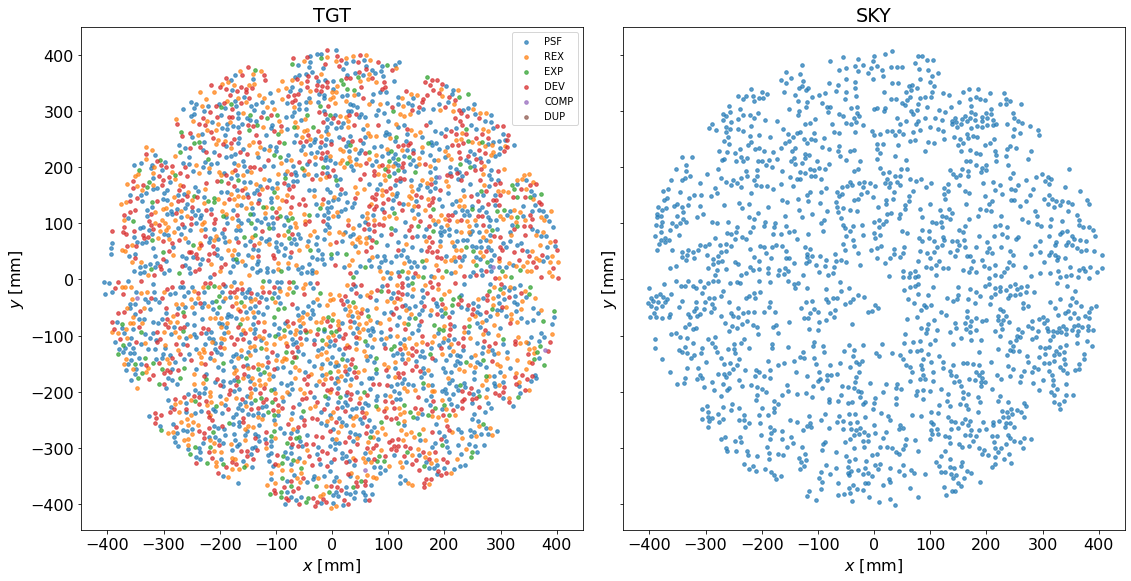

In [11]:
fig, axes = plt.subplots(1,2, figsize=(16,8), sharex=True, sharey=True)

ax = axes[0]
for mtype in ['PSF', 'REX', 'EXP', 'DEV', 'COMP', 'DUP']:
    mcut = morph == mtype
    ax.scatter(x[tgt & mcut], y[tgt & mcut], s=13, alpha=0.7, label=mtype)
ax.legend(fontsize=10)
ax.set(aspect='equal', title='TGT', xlabel='$x$ [mm]', ylabel='$y$ [mm]')

ax = axes[1]
ax.scatter(x[sky], y[sky], s=13, alpha=0.7)
ax.set(aspect='equal', title='SKY', xlabel='$x$ [mm]', ylabel='$y$ [mm]')

fig.tight_layout();

## Best-Fit Redshifts from Redrock

In [12]:
zbest_files = sorted(glob('/global/project/projectdirs/desi/spectro/redux/daily/tiles/68000/20200314/zbest*.fits'))
zbest_files

['/global/project/projectdirs/desi/spectro/redux/daily/tiles/68000/20200314/zbest-0-68000-20200314.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/68000/20200314/zbest-1-68000-20200314.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/68000/20200314/zbest-2-68000-20200314.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/68000/20200314/zbest-3-68000-20200314.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/68000/20200314/zbest-4-68000-20200314.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/68000/20200314/zbest-5-68000-20200314.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/68000/20200314/zbest-6-68000-20200314.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/68000/20200314/zbest-7-68000-20200314.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/68000/20200314/zbest-8-68000-20200314.fits',
 '/global/project/projectdirs/desi/spectro/red

### Joined Redshift Tables and Fibermaps

Read through all fibers in all petals and get the ZBEST and FIBERMAP tables.

In [13]:
zbests = None
zb_fibermaps = None

for zbf in zbest_files:
    if zbests is None:
        zbests = Table.read(zbf, 'ZBEST')
        zb_fibermaps = Table.read(zbf, 'FIBERMAP')
    else:
        zbests = vstack([zbests, Table.read(zbf, 'ZBEST')])
        zb_fibermaps = vstack([zb_fibermaps, Table.read(zbf, 'FIBERMAP')])

In [14]:
np.unique(zb_fibermaps['OBJTYPE']), np.unique(zbests['SPECTYPE'])

(<Column name='OBJTYPE' dtype='bytes3' length=2>
 SKY
 TGT,
 <Column name='SPECTYPE' dtype='bytes6' length=3>
 GALAXY
    QSO
   STAR)

In [15]:
zb_fibermaps

TARGETID,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,PMRA_IVAR,PMDEC_IVAR,REF_EPOCH,LAMBDA_REF,FA_TARGET,FA_TYPE,OBJTYPE,FIBERASSIGN_X,FIBERASSIGN_Y,NUMTARGET,PRIORITY,SUBPRIORITY,OBSCONDITIONS,NUMOBS_MORE,RELEASE,BRICKID,BRICKNAME,BRICK_OBJID,MORPHTYPE,TARGET_RA_IVAR,TARGET_DEC_IVAR,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,FRACFLUX_G,FRACFLUX_R,FRACFLUX_Z,FRACMASKED_G,FRACMASKED_R,FRACMASKED_Z,FRACIN_G,FRACIN_R,FRACIN_Z,NOBS_G,NOBS_R,NOBS_Z,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,ALLMASK_G,ALLMASK_R,ALLMASK_Z,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,WISEMASK_W1,WISEMASK_W2,MASKBITS,FRACDEV,FRACDEV_IVAR,SHAPEDEV_R,SHAPEDEV_E1,SHAPEDEV_E2,SHAPEDEV_R_IVAR,SHAPEDEV_E1_IVAR,SHAPEDEV_E2_IVAR,SHAPEEXP_R,SHAPEEXP_E1,SHAPEEXP_E2,SHAPEEXP_R_IVAR,SHAPEEXP_E1_IVAR,SHAPEEXP_E2_IVAR,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_RP_MEAN_MAG,GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_RP_EXCESS_FACTOR,GAIA_ASTROMETRIC_EXCESS_NOISE,GAIA_DUPLICATED_SOURCE,GAIA_ASTROMETRIC_SIGMA5D_MAX,GAIA_ASTROMETRIC_PARAMS_SOLVED,PARALLAX,PARALLAX_IVAR,PHOTSYS,CMX_TARGET,PRIORITY_INIT,NUMOBS_INIT,HPXPIXEL,BLOBDIST,FIBERFLUX_IVAR_G,FIBERFLUX_IVAR_R,FIBERFLUX_IVAR_Z,DESI_TARGET,BGS_TARGET,MWS_TARGET,NUM_ITER,FIBER_X,FIBER_Y,MEAN_DELTA_X,MEAN_DELTA_Y,FIBER_RA,FIBER_DEC,COADD_NUMEXP,RMS_DELTA_X,RMS_DELTA_Y,FIRST_FIBER,LAST_FIBER,NUM_FIBER
int64,int16,int32,int64,int32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int64,uint8,bytes3,float32,float32,int16,int32,float64,int32,int64,int16,int32,bytes8,int32,bytes4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,uint8,uint8,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,bytes2,float32,float32,float32,float32,float32,float32,float32,float32,bool,float32,bool,float32,float32,bytes1,int64,int64,int64,int64,float32,float32,float32,float32,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,int16,float64,float64,int64,int64,int64
35191248222424145,0,509,509,353,0,214.4915008097018,51.85985927893284,-13.968278,-0.8086239,49.491528,53.194283,2015.5,5400.0,42949673511,3,TGT,39.578968,-389.6408,0,100,0.45563114425525797,65535,100,8001,590822,2144p517,3153,PSF,2646198600000000.0,2231917300000000.0,0.00838432,80.17179,104.47831,105.898254,51.180035,40.88282,32.569424,0.97548616,0.9834203,0.99069196,1.5303195e-10,7.86668e-10,3.615868e-08,0.20385678,0.022875372,0.17757826,0.9999988,0.9999983,0.9999978,3,4,3,585.86066,309.23462,109.99242,422.08148,194.14775,59.241077,113.301414,32.438644,30.973074,307.66504,6.247066,1.1526513,0.0020091694,2.4345865e-05,0.9985801,0.99912775,0.9998139,0.9999297,0,0,0,62.126644,80.962234,82.06258,62.126644,80.962234,82.06258,163,162,2818,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1607815239118702848,G2,17.510342,846.1814,17.727562,155.63768,17.08302,166.45024,1.2317004,0.13897403,True,0.13220444,True,0.029689165,114.10905,N,42949673511,2675,1,11424,0.0,0.0,0.0,0.0,42949672960,0,0,3,39.502,-389.439,0.0045000000000000005,-0.005000000000000001,0.0,0.0,2,0.004527692569068709,0.013000000000000001,353,353,1
35191248222424269,0,520,520,471,0,214.62058871620775,51.812722022487186,0.0,0.0,0.0,0.0,2015.5,5400.0,3602879

In [16]:
zbests

TARGETID,CHI2,COEFF [10],Z,ZERR,ZWARN,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,NUMEXP,NUMTILE
int64,float64,float64,float64,float64,int64,int64,bytes6,bytes20,int64,float64,int32,int32
35191248222424145,7259.800508832185,8063.0291360884785 .. 0.0,-0.0002886153443641642,7.451629002944611e-06,0,7745,STAR,F,5,6864.968405212082,0,0
35191248222424269,9024.102805782575,372.16247336886374 .. -21.685308398153815,0.06910871245634506,4.686121544557325e-05,4,7755,GALAXY,,10,1.0743626500479877,0,0
35191248222424420,8986.028667137027,-22.482152978713707 .. -28.61314870503862,0.4941971161917882,6.728390307333448e-05,4,7755,GALAXY,,10,1.0081577748060226,0,0
35191248222424578,8938.875866990536,193.73714407065953 .. -20.20769458514503,0.2996033871008,7.462166661592696e-05,0,7749,GALAXY,,10,223.85453417152166,0,0
35191248222424614,9070.604154258966,148.49034010474506 .. -36.752563303933464,0.6771526334509526,7.56654140419623e-05,0,7754,GALAXY,,10,100.05211579054594,0,0
35191248222424642,8711.680719568387,303.43380183098935 .. 0.0,-9.313205113169704e-05,3.0133053509726338e-05,0,7746,STAR,K,5,34.42271779807197,0,0
35191248226617964,9229.168636761606,-3.1191815640578474e-05 .. 0.0,0.9948622069101263,0.0001336458363980782,4,7751,QSO,,4,6.77254430949688,0,0
35191248226618062,8.999999999999996e+99,0.0 .. 0.0,-0.0019957014509158224,4.131159871613317e-48,1570,0,STAR,CV,3,1.942668892225729e+84,0,0
35191248226618068,9221.893169283867,62.87460913151523 .. 4.611629919049688,0.909818763027433,7.706431049173938e-05,4,7751,GALAXY,,10,2.3227899074554443,0,0


### Selection

Select fibers not targeted on sky.

In [17]:
tgt = zb_fibermaps['OBJTYPE'] == 'TGT'
sky = zb_fibermaps['OBJTYPE'] == 'SKY'

gal  = zbests['SPECTYPE'] == 'GALAXY'
qso  = zbests['SPECTYPE'] == 'QSO'
star = zbests['SPECTYPE'] == 'STAR'

In [18]:
z     = zbests['Z']
zerr  = zbests['ZERR']
zwarn = zbests['ZWARN']
dchi2 = zbests['DELTACHI2']

In [19]:
np.sum(zwarn[gal] == 0)

1702

996


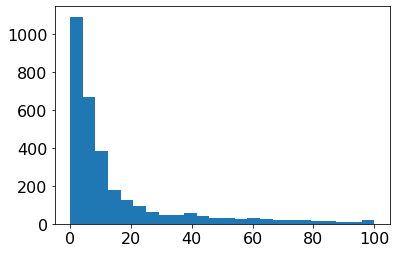

In [20]:
plt.hist(dchi2[gal], bins=np.linspace(0,100,25))
print(np.sum(dchi2[gal] > 25))

### Redshifts

Plot redshifts of galaxies, QSOs, and stars for fibers explicitly assigned to targets.

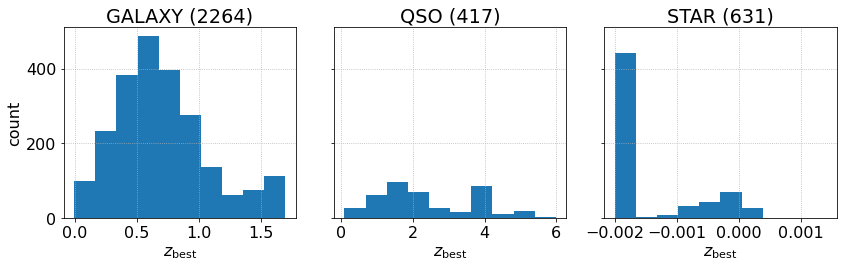

In [21]:
fig, axes = plt.subplots(1,3, figsize=(12,4), sharey=True)

for ax, sptype in zip(axes, ['GALAXY', 'QSO', 'STAR']):
    sel = zbests['SPECTYPE'] == sptype
    objcount = np.sum(tgt & sel)
    
    ax.hist(z[tgt & sel])
    ax.set(xlabel='$z_\mathrm{best}$',
           title='{} ({:d})'.format(sptype, objcount))
    ax.grid(ls=':')
           
axes[0].set(ylabel='count')

fig.tight_layout();

### Redshifts of BGS Targets

Use the CMX bitmasks to pick out just BGS targets from the tile, if there are any.

In [22]:
bgs_select = np.full(len(zbests), True)

cmx_isBGS  = zb_fibermaps['CMX_TARGET'] & cmx_mask.mask(cmx_bgs_bits) != 0
desi_isBGS = zb_fibermaps['DESI_TARGET'] & desi_mask.mask(desi_bgs_bits) != 0

np.sum(cmx_isBGS), np.sum(desi_isBGS)

(376, 0)

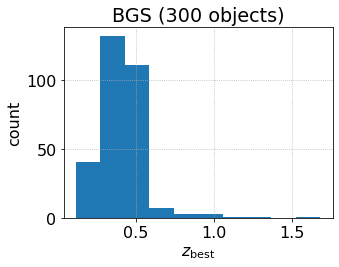

In [23]:
fig, ax = plt.subplots(1,1, figsize=(5,4), sharey=True)

sel = tgt & gal & cmx_isBGS
objcount = np.sum(tgt & gal & cmx_isBGS)
    
ax.hist(z[sel])
ax.set(xlabel='$z_\mathrm{best}$',
       ylabel='count',
       title='{} ({:d} objects)'.format('BGS', objcount))
ax.grid(ls=':')

fig.tight_layout();

### Access Spectra Classified as "GALAXY" Type with BGS Bitmasks

In [24]:
bgs_targetids = zb_fibermaps['TARGETID'][sel]
bgs_petalids  = zb_fibermaps['PETAL_LOC'][sel]

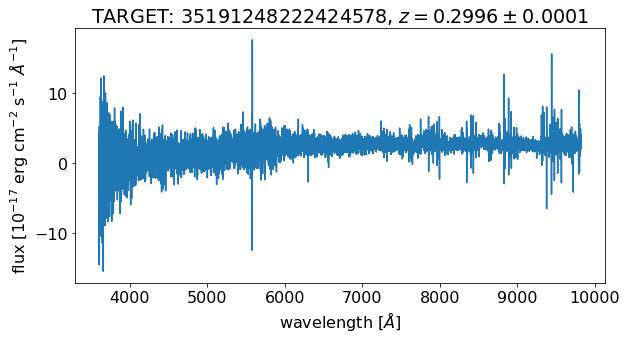

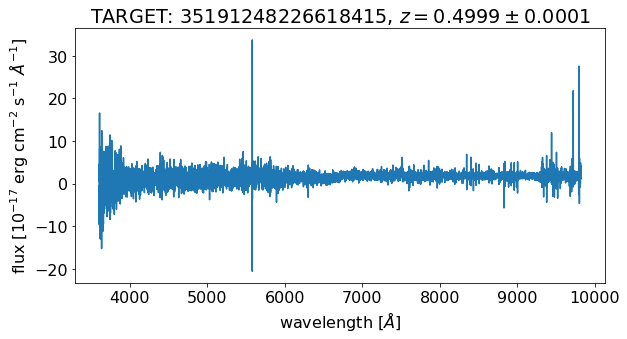

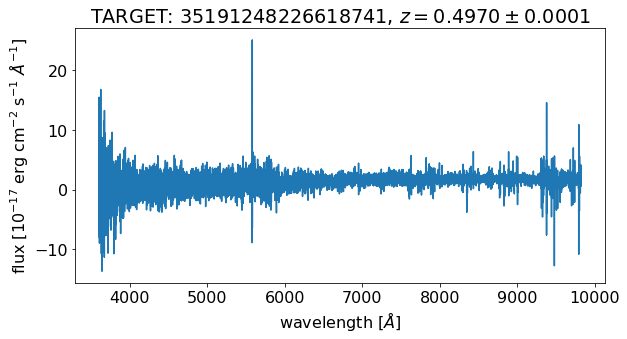

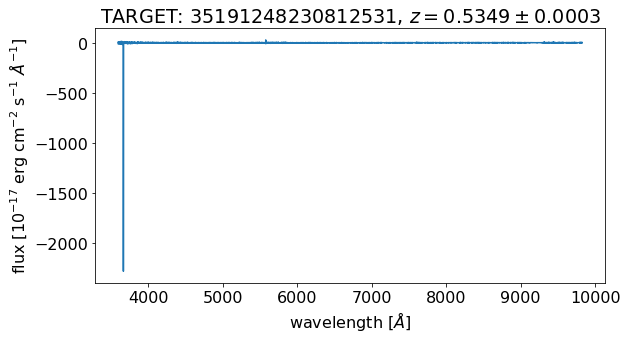

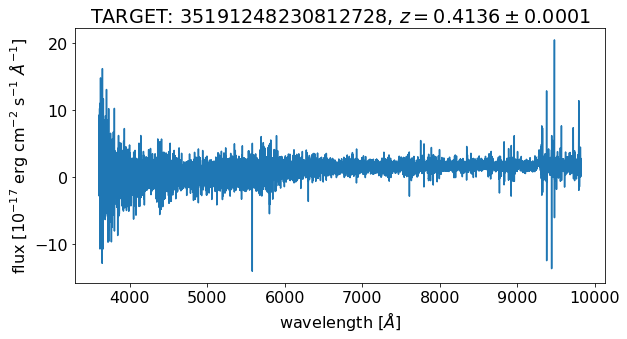

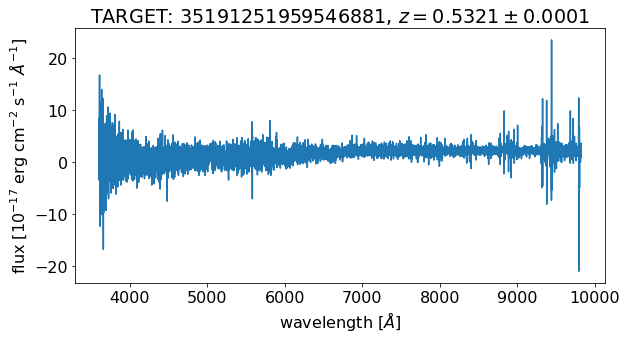

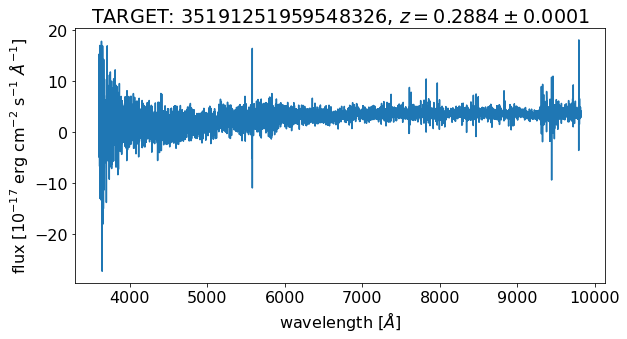

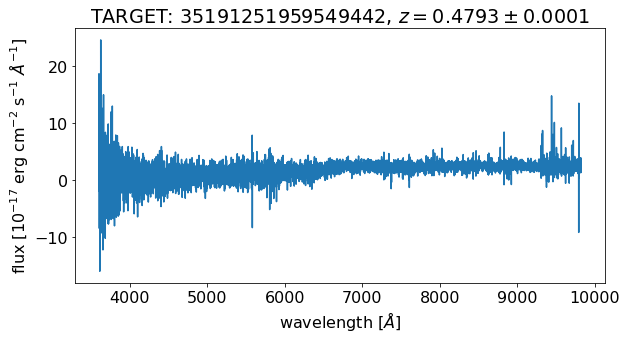

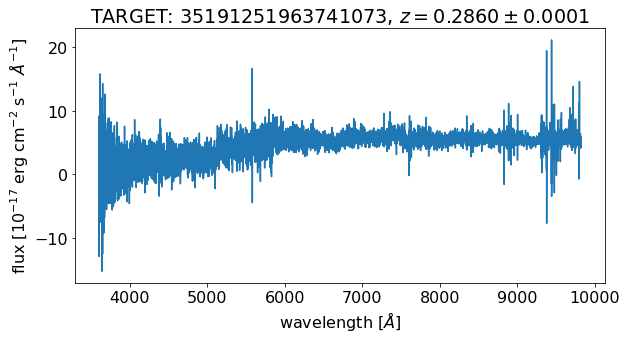

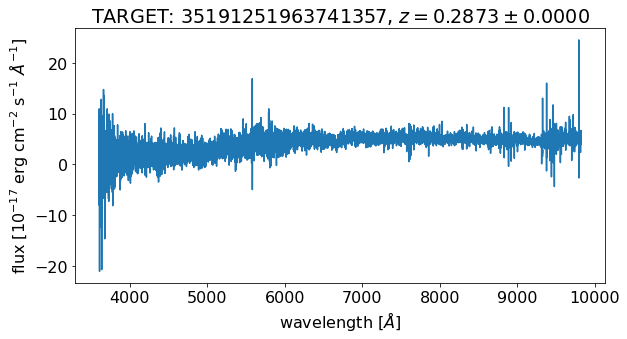

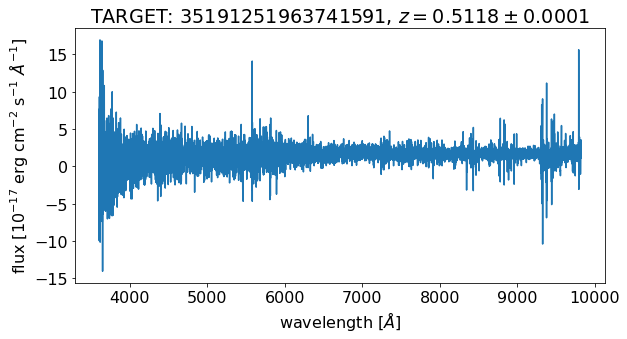

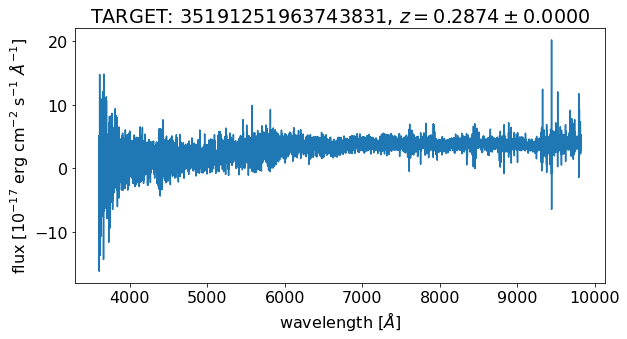

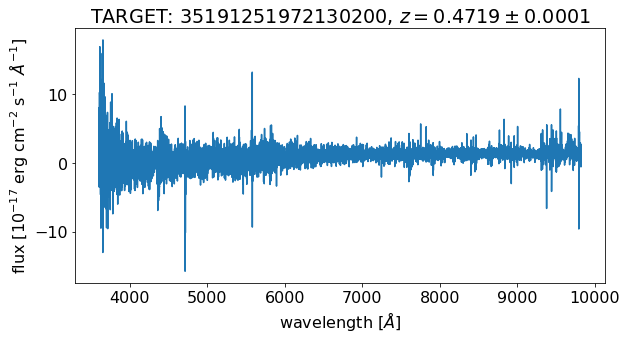

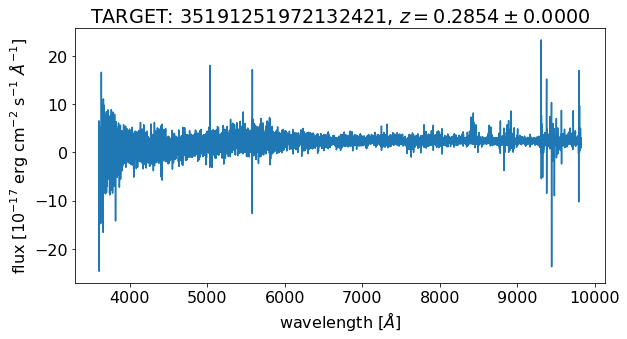

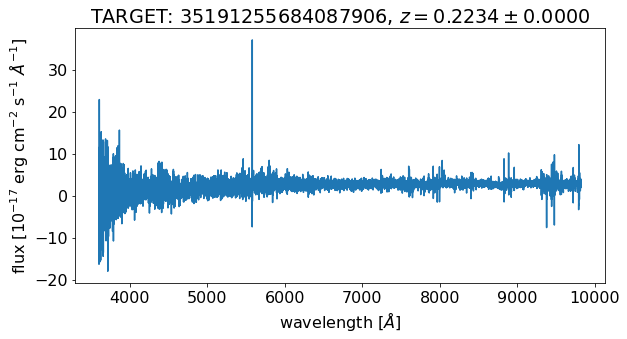

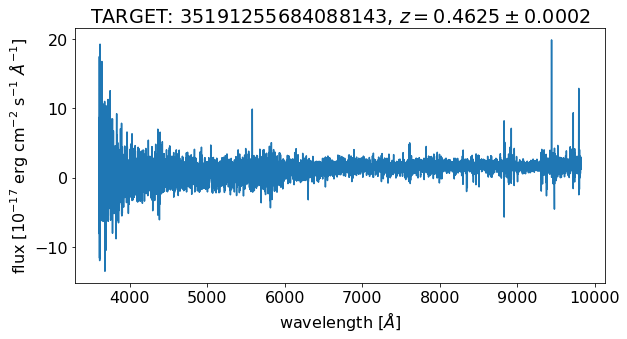

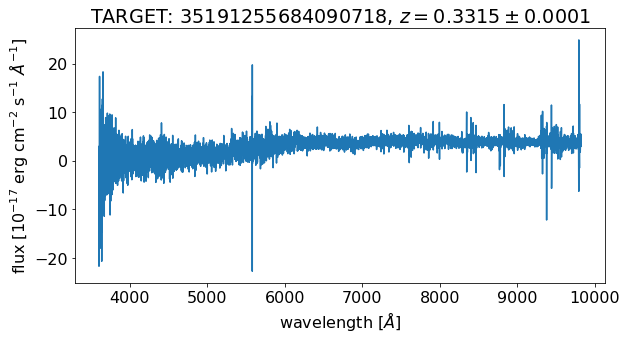

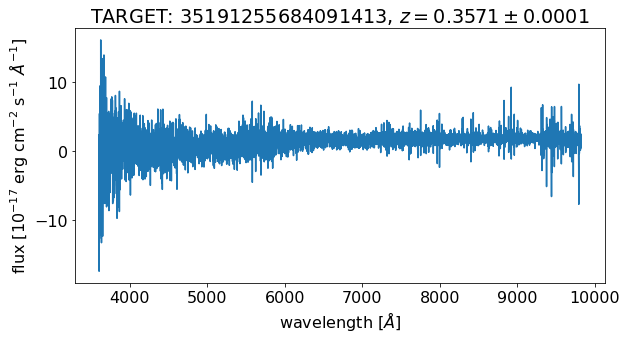

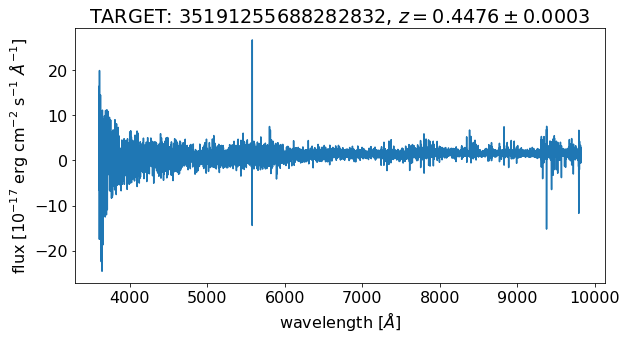

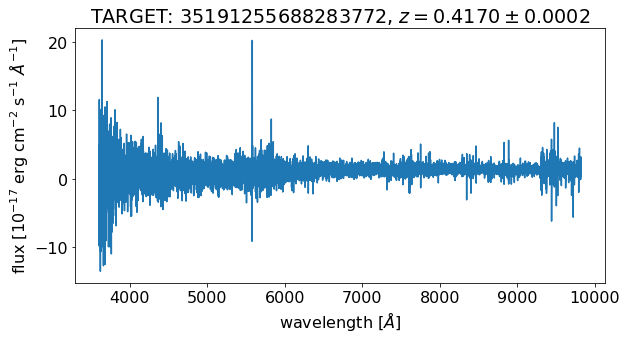

In [25]:
idx = np.argwhere(np.in1d(zb_fibermaps['TARGETID'], bgs_targetids))
for coadd in coadds:
    spectra = read_spectra(coadd)
    idx = np.argwhere(np.in1d(spectra.fibermap['TARGETID'], bgs_targetids)).flatten()
    if len(idx) > 0:
        for i, j in enumerate(idx):
            targid = spectra.fibermap['TARGETID'][j]
            z_idx = np.argwhere(np.in1d(zbests['TARGETID'], targid)).flatten()
            z_bf  = zbests['Z'][z_idx][0]
            dz_bf = zbests['ZERR'][z_idx][0]
            fig, ax = plt.subplots(1,1, figsize=(9,5), tight_layout=True)
            ax.plot(spectra.wave['brz'], spectra.flux['brz'][j])
            ax.set(xlabel=r'wavelength [$\AA$]',
                   ylabel=r'flux [$10^{-17}$ erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$]',
                   title='TARGET: {}, $z={:.4f}\pm{:.4f}$'.format(targid, z_bf, dz_bf))
            if i >= 19:
                break
        break

### Fiber Assignment (Galaxies and Morphology)

Plot the fiber positions classified by GALAXY SPECTYPE in zbest and by object morphology from the Legacy Survey. See [legacysurvey.org](https://legacysurvey.org) for descriptions of the available morphologies. From DR8:
1. PSF  - pointlike (stars, QSOs, distant galaxies)
2. REX  - round exponential fit (galaxies with variable radius)
3. EXP  - exponential fit (spiral galaxies)
4. DEV  - deVaucouleurs (elliptical galaxies)
5. COMP - composite (deVaucouleurs + exponential)
 DUP  - extended source coincident with Gaia source

In [26]:
morph = zb_fibermaps['MORPHTYPE']
x   = zb_fibermaps['FIBERASSIGN_X']
y   = zb_fibermaps['FIBERASSIGN_Y']
ra  = zb_fibermaps['TARGET_RA']
dec = zb_fibermaps['TARGET_DEC']

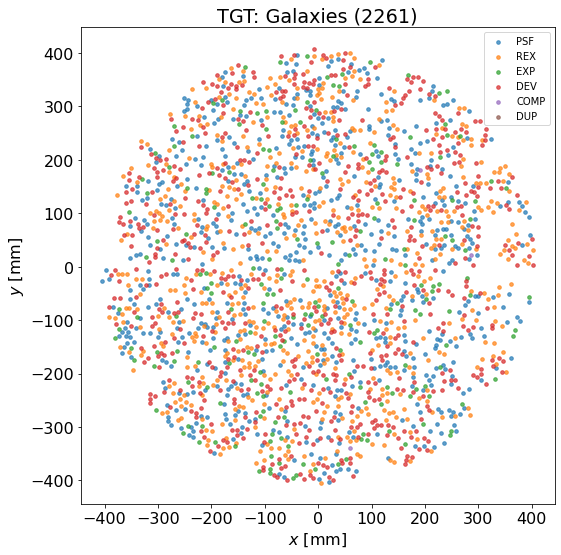

In [27]:
fig, ax = plt.subplots(1,1, figsize=(9,8))

objcount = 0
for mtype in ['PSF', 'REX', 'EXP', 'DEV', 'COMP', 'DUP']:
    mcut = morph == mtype
    selection = tgt & mcut & gal
    objcount += np.sum(selection)
    
    ax.scatter(x[selection], y[selection], s=13, alpha=0.7, label=mtype)
    
ax.legend(fontsize=10)
ax.set(aspect='equal', title='TGT: Galaxies ({:d})'.format(objcount),
       xlabel='$x$ [mm]', ylabel='$y$ [mm]')

fig.tight_layout();

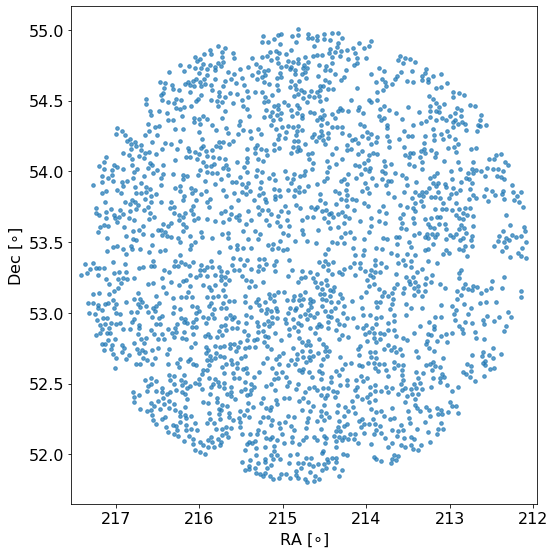

In [28]:
fig, ax = plt.subplots(1,1, figsize=(8,8))

ax.scatter(ra[tgt & gal], dec[tgt & gal], s=13, alpha=0.7)
ra_min = np.min(ra)
ra_max = np.max(ra)
ax.set(xlim=(0.1+ra_max, ra_min-0.1),
       xlabel=r'RA [$\circ$]',
       ylabel=r'Dec [$\circ$]')

fig.tight_layout()